In [49]:
import pandas as pd
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import pandas as pd
import platform


# 한글 폰트 설정
if platform.system() == 'Darwin':  
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  
    rc('font', family='Malgun Gothic')
else:  
    rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

#2020년까지의 데이터만 사용
pce_yoy = pd.read_csv('./data/korea_pce_monthly_yoy.csv', index_col=0, parse_dates=True)['2000-12-31':'2020-12-31']
WTI_yoy = pd.read_csv('./data/WTI_yoy.csv', index_col=0, parse_dates=True)['2000-12-31':'2020-12-31']

<Axes: >

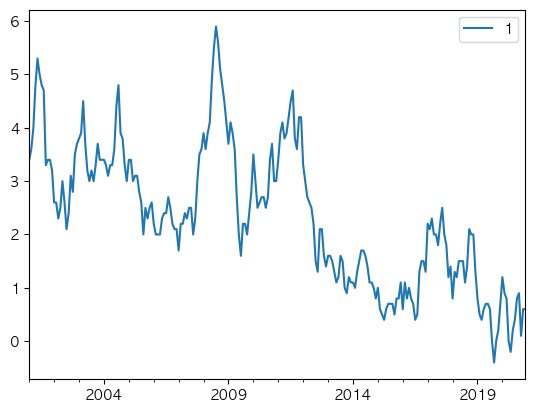

In [51]:
pce_yoy.plot()

Multiprocess sampling (7 chains in 7 jobs)
CompoundStep
>NUTS: [beta1, beta2, sigma2_1, sigma2_2]
>Metropolis: [tau]


Output()

Sampling 7 chains for 5_000 tune and 10_000 draw iterations (35_000 + 70_000 draws total) took 453 seconds.
There were 938 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


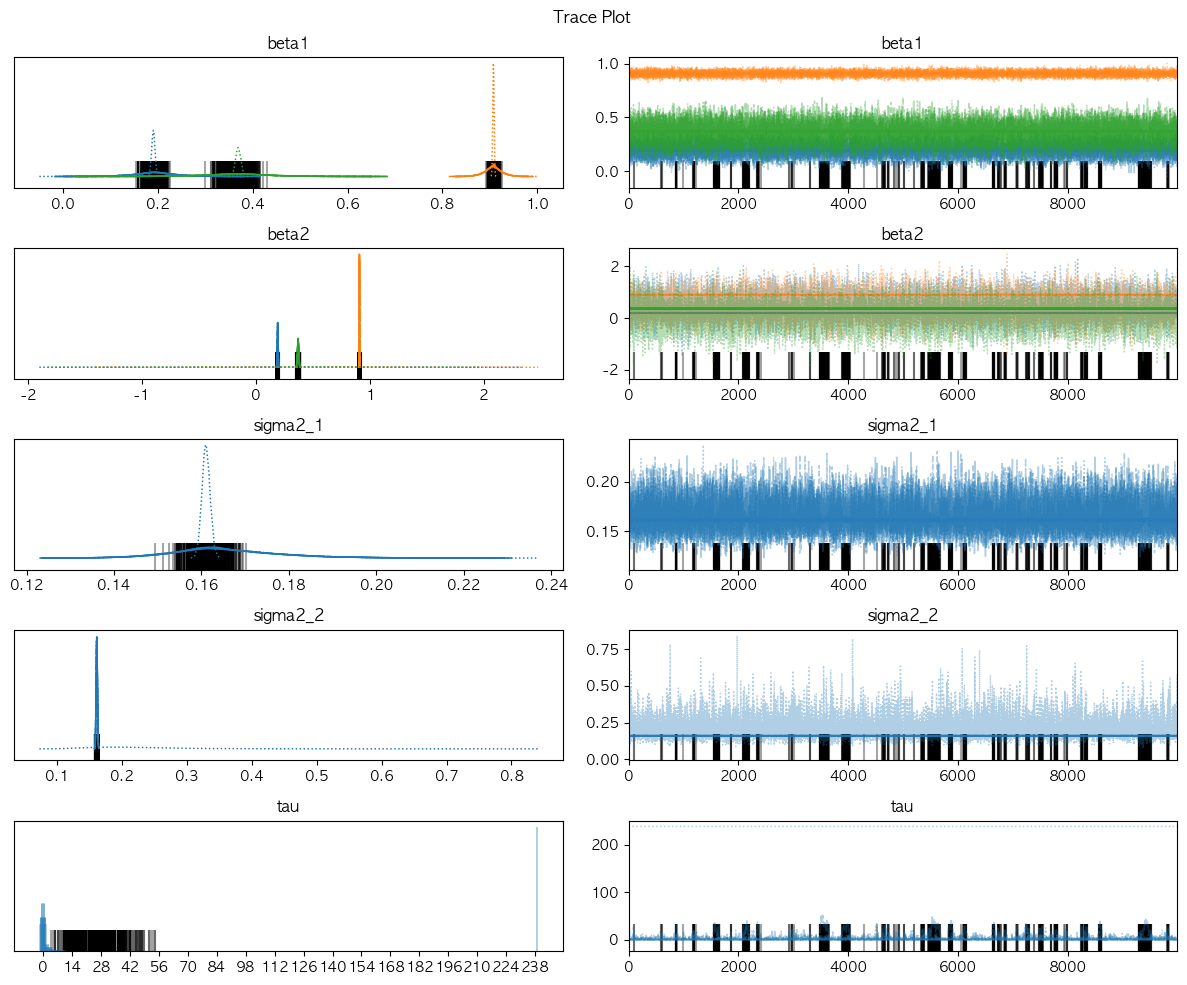

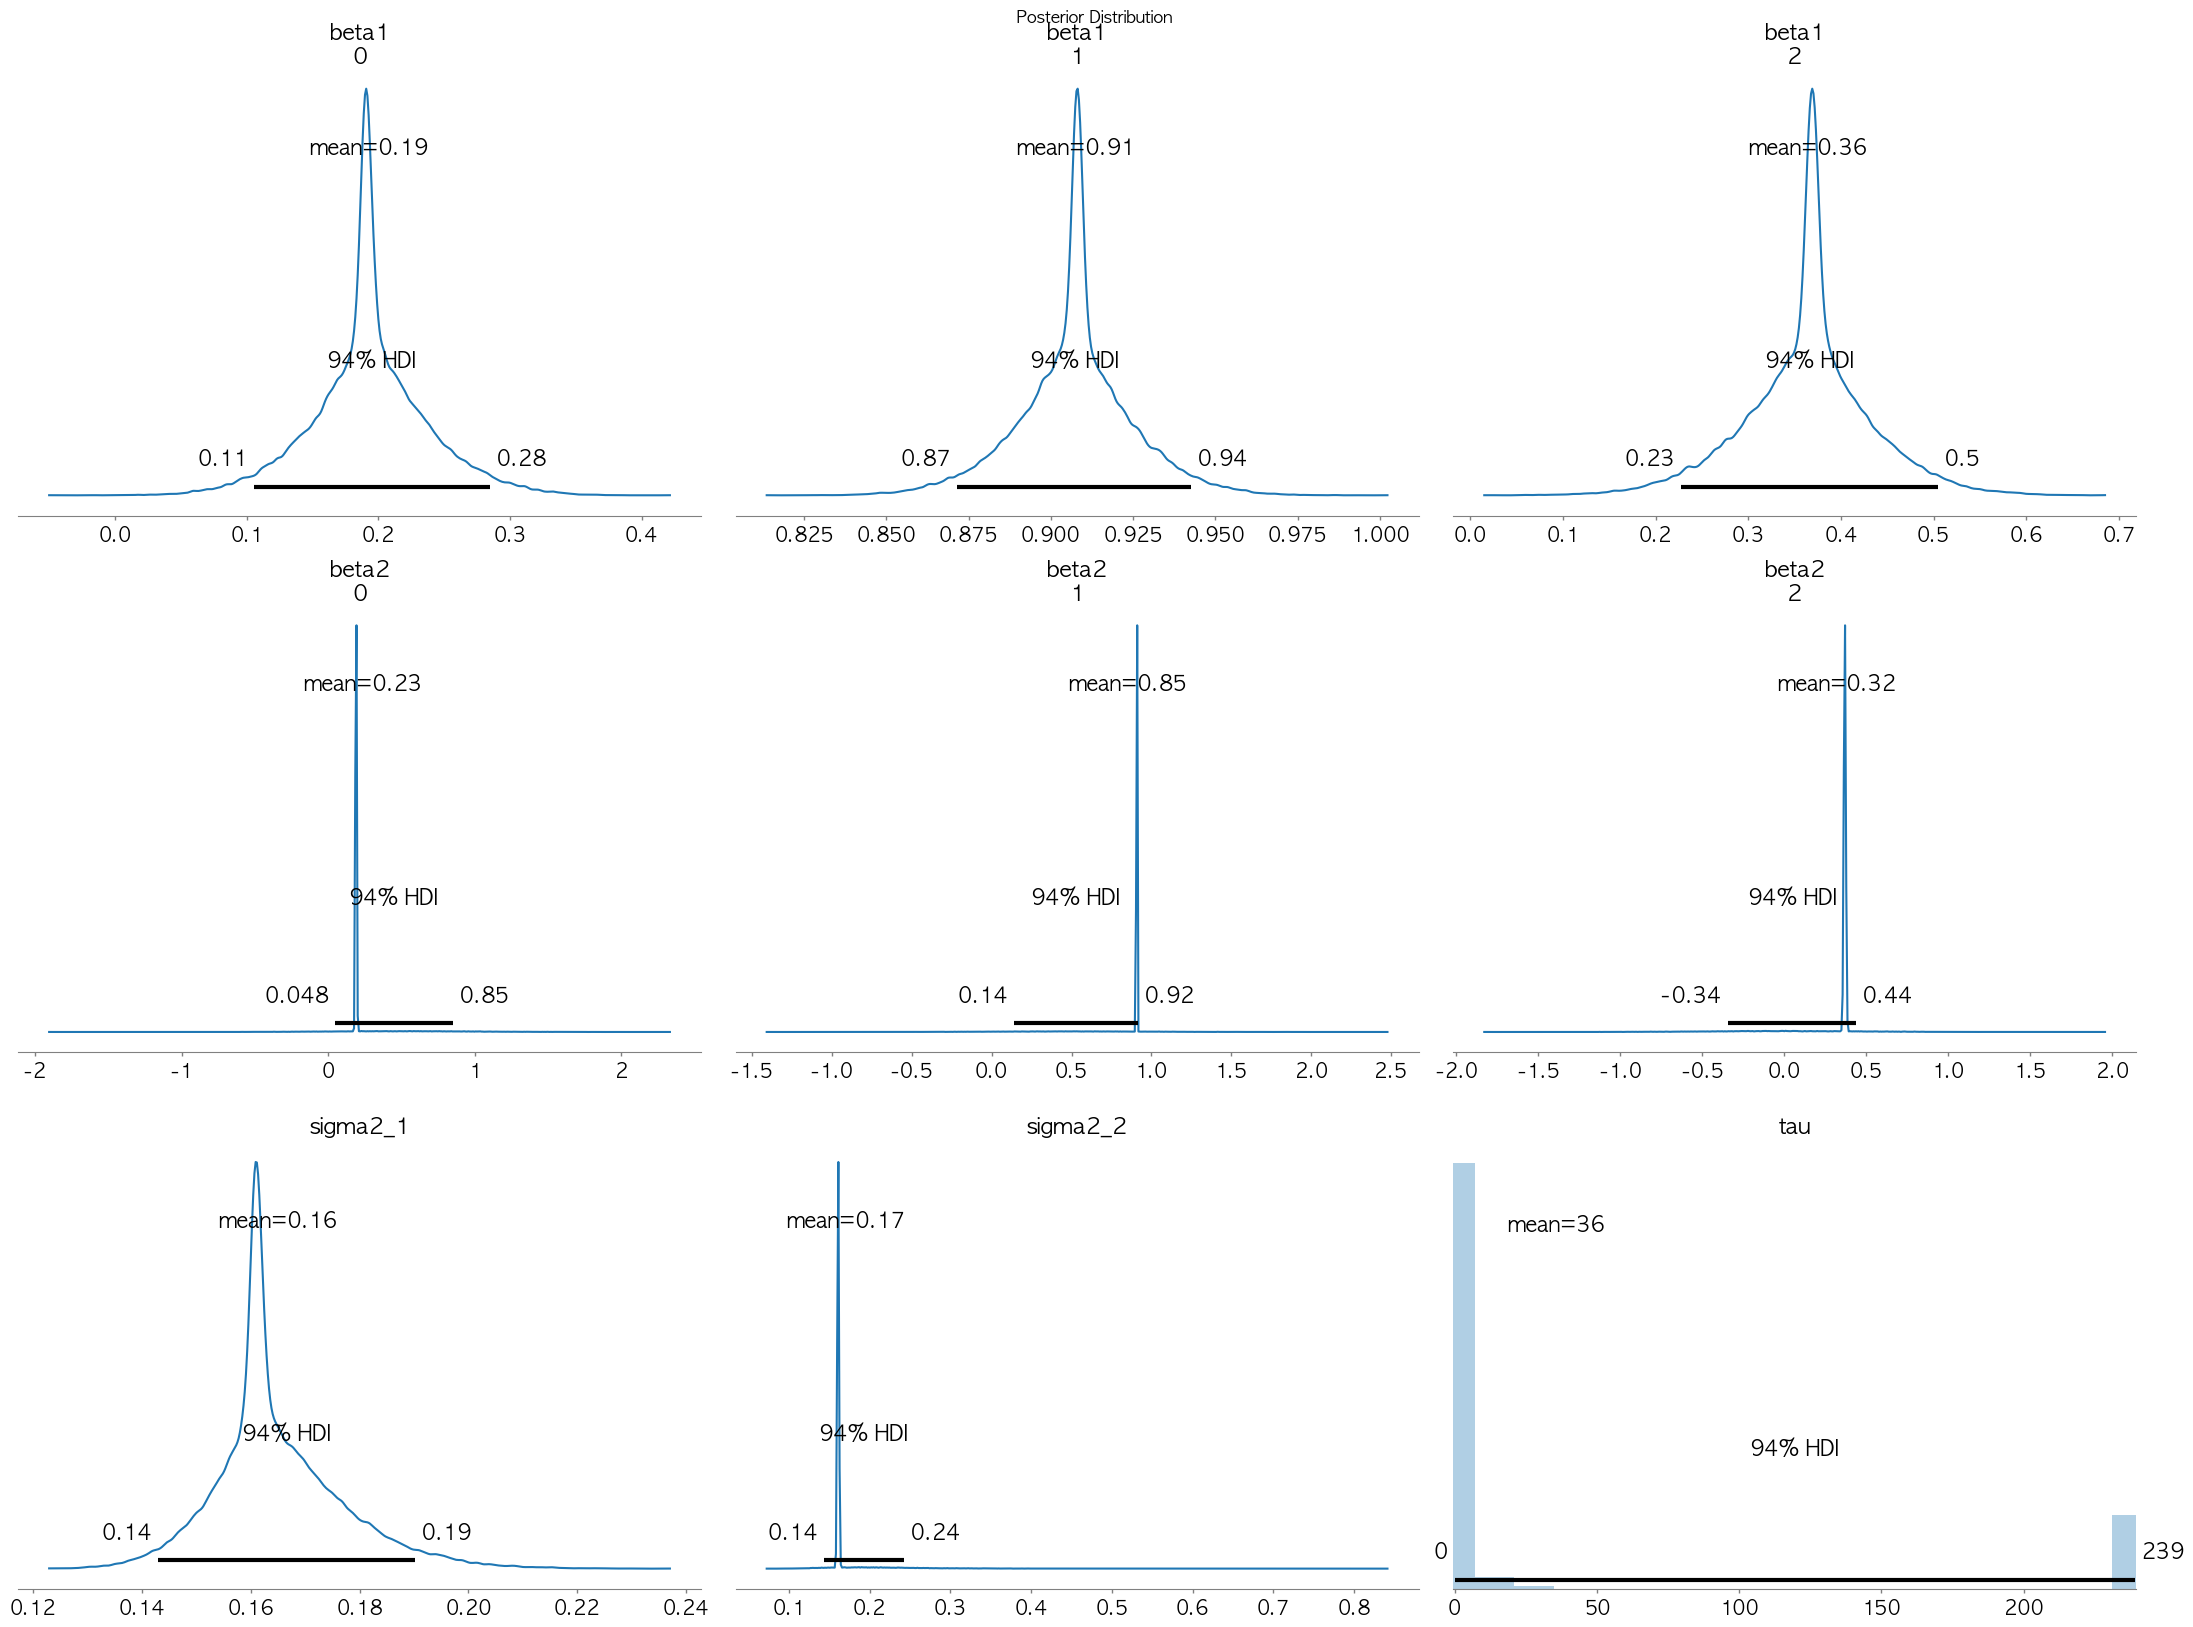

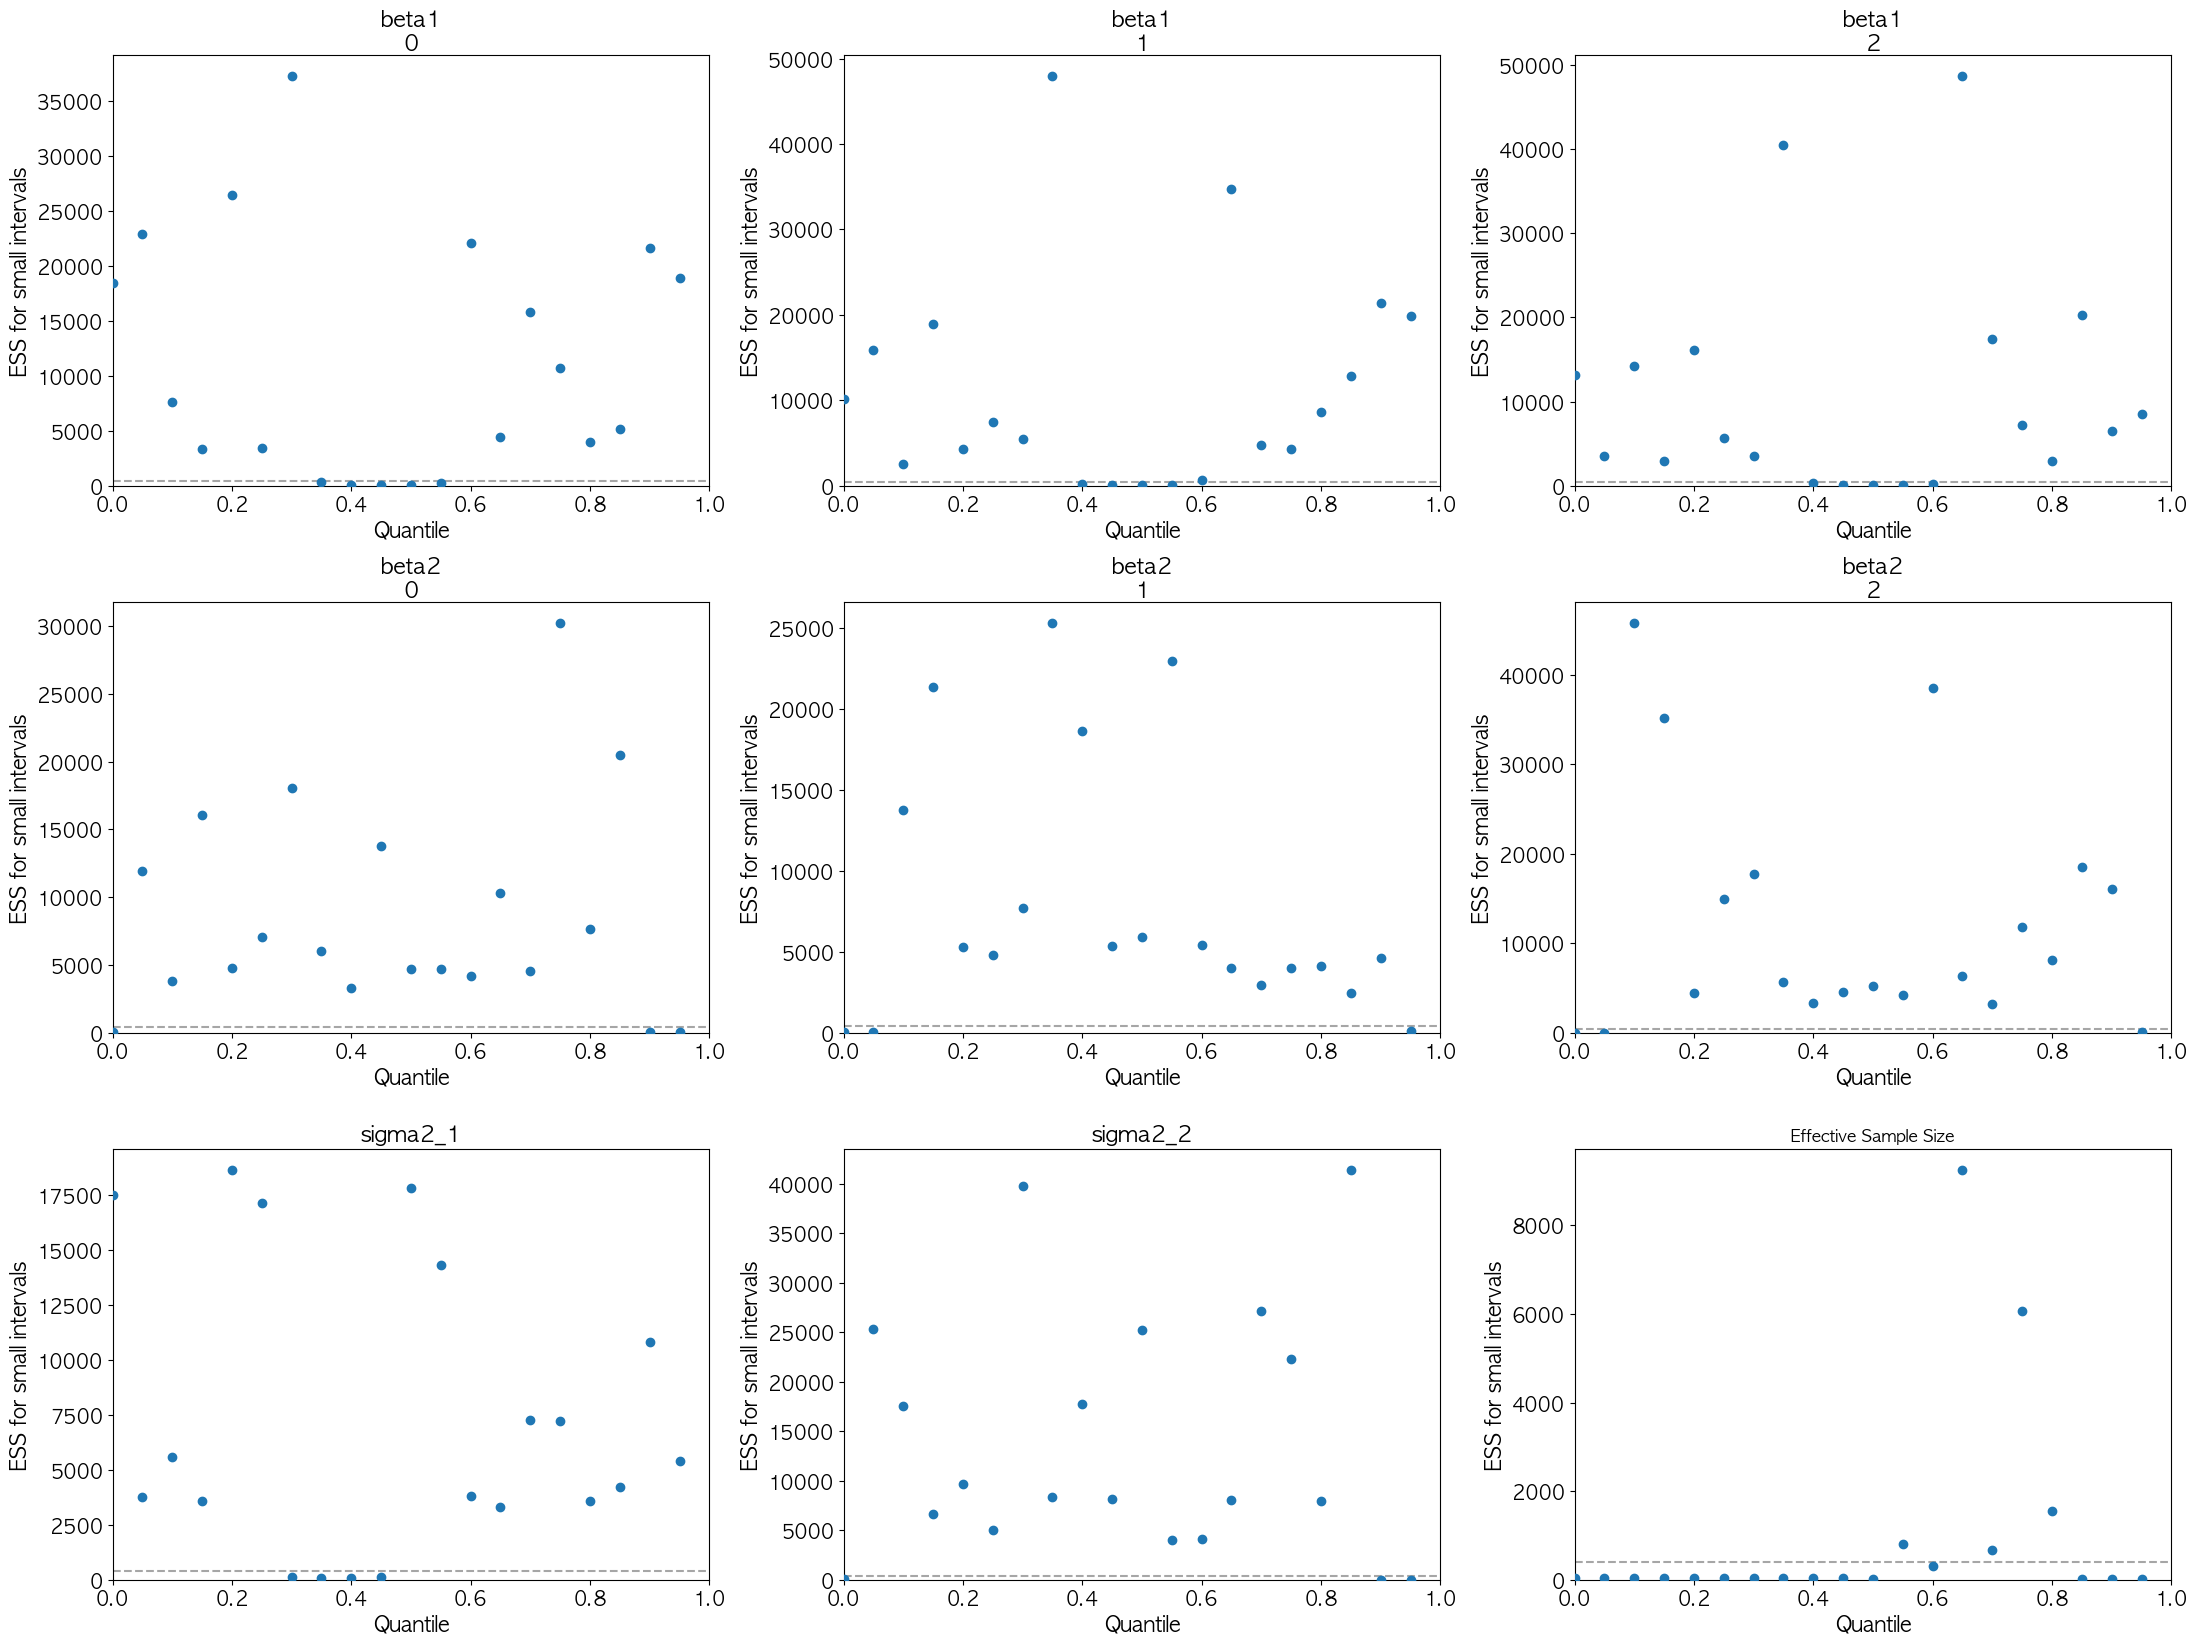

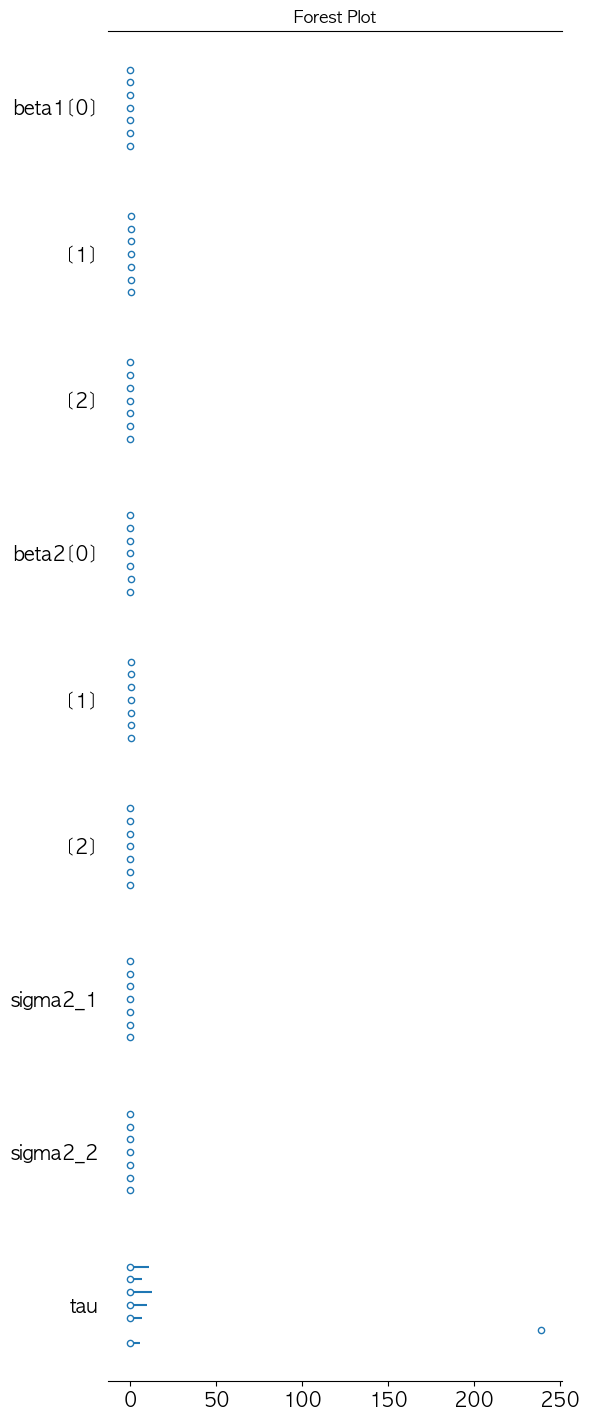

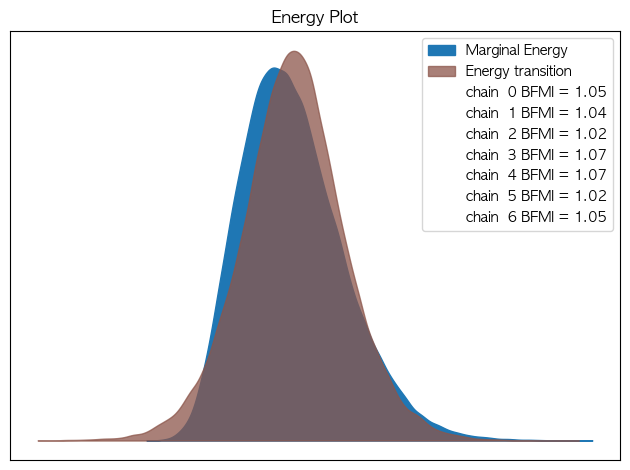

Summary Statistics:
            mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta1[0]   0.193   0.044   0.106    0.284      0.000    0.000   34566.0   
beta1[1]   0.907   0.018   0.872    0.943      0.000    0.000   33654.0   
beta1[2]   0.364   0.069   0.228    0.504      0.000    0.000   51554.0   
beta2[0]   0.233   0.214   0.048    0.848      0.039    0.033      97.0   
beta2[1]   0.850   0.233   0.137    0.918      0.054    0.039      53.0   
beta2[2]   0.318   0.225  -0.344    0.440      0.048    0.034      67.0   
sigma2_1   0.165   0.012   0.143    0.190      0.000    0.000    2164.0   
sigma2_2   0.170   0.036   0.144    0.242      0.008    0.006      54.0   
tau       35.749  83.096   0.000  239.000     31.352   23.195      13.0   

          ess_tail  r_hat  
beta1[0]   18466.0   1.19  
beta1[1]   10153.0   1.19  
beta1[2]    8538.0   1.19  
beta2[0]      22.0   1.32  
beta2[1]      22.0   1.33  
beta2[2]      22.0   1.32  
sigma2_1    5381.0   1.13  
sigma

/var/folders/2b/7cp_kgpx56d9_ln5r0n4nm8h0000gn/T/ipykernel_3681/880953593.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start='2000-01-01', periods=len(y), freq='M')


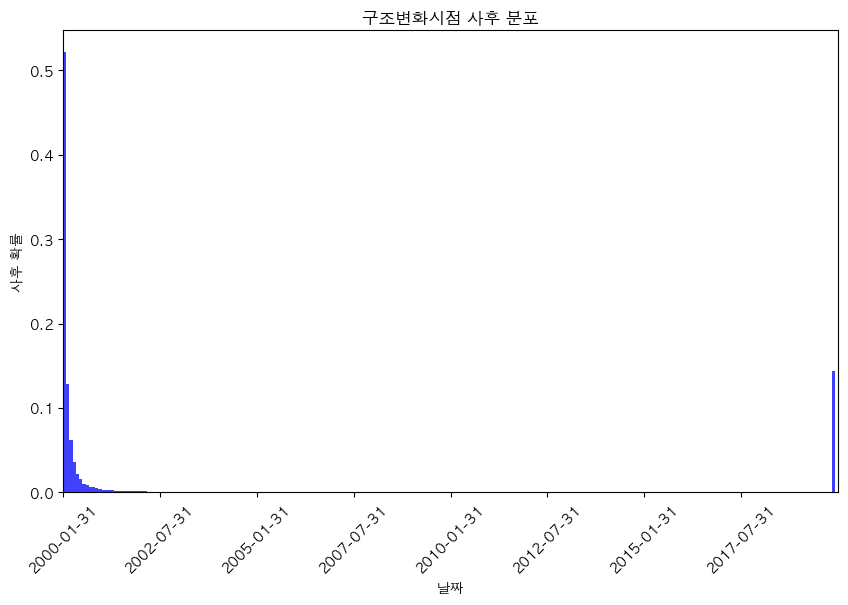

In [89]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

y = pce_yoy.values  # 물가상승률 데이터 (대체)
x = WTI_yoy.values  # 설명 변수 데이터

with pm.Model() as model:
    # 파라미터 설정은 그대로 유지
    beta1_prior = pm.MvNormal('beta1', mu=np.array([0.5, 0.5, 0]), cov=0.25 * np.eye(3), shape=3)
    beta2_prior = pm.MvNormal('beta2', mu=np.array([0.5, 0.5, 0]), cov=0.25 * np.eye(3), shape=3)
    
    c1_prior = beta1_prior[0]
    phi1_prior = beta1_prior[1]
    rho1_prior = beta1_prior[2]
    c2_prior = beta2_prior[0]
    phi2_prior = beta2_prior[1]
    rho2_prior = beta2_prior[2]
    
    # 시그마^2의 InverseGamma 분포
    sigma2_1_prior = pm.InverseGamma('sigma2_1', alpha=10, beta=2)
    sigma2_2_prior = pm.InverseGamma('sigma2_2', alpha=10, beta=2)
    
    # 구조변화 시점 τ: 균등분포에서 샘플링
    tau = pm.DiscreteUniform('tau', lower=0, upper=len(y)-1)
    
    # 선형 회귀식 (구조 변화 전후로 다른 식 사용)
    mu1 = c1_prior + phi1_prior * np.roll(y, 1) + rho1_prior * np.roll(x, 1)
    mu2 = c2_prior + phi2_prior * np.roll(y, 1) + rho2_prior * np.roll(x, 1)
    
    # likelihood: 구조변화 시점에 따라 다른 mu와 sigma를 사용
    # `tau`를 기준으로 `y_t`의 평균과 분산을 다르게 설정
    mu = pm.math.switch(np.arange(len(y)) <= tau, mu1, mu2)  # 각 시점에 대해 mu 선택
    sigma = pm.math.switch(np.arange(len(y)) <= tau, pm.math.sqrt(sigma2_1_prior), pm.math.sqrt(sigma2_2_prior))  # 각 시점에 대한 sigma 선택
    
    # 관측된 데이터에 대한 likelihood 설정
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    # 샘플링
    trace = pm.sample(10000, return_inferencedata=True, tune=5000, target_accept=0.95, cores=7, chains=7)
    
    az.plot_trace(trace)
    plt.suptitle("Trace Plot")
    plt.tight_layout()
    plt.show()
    az.plot_posterior(trace)
    plt.suptitle("Posterior Distribution")
    plt.tight_layout()
    plt.show()
    az.plot_ess(trace)
    plt.title("Effective Sample Size")
    plt.tight_layout()
    plt.show()
    az.plot_forest(trace)
    plt.title("Forest Plot")
    plt.tight_layout()
    plt.show()
    az.plot_energy(trace)
    plt.title("Energy Plot")
    plt.tight_layout()
    plt.show()
    summary = az.summary(trace)
    print("Summary Statistics:")
    print(summary)
    # 구조변화시점 사후 분포 플롯
    tau_samples = trace.posterior['tau'].values.flatten()
    plt.figure(figsize=(10, 6))
    plt.hist(tau_samples, bins=len(y), density=True, alpha=0.75, color='blue')
    plt.title('구조변화시점 사후 분포')
    plt.xlabel('날짜')
    plt.ylabel('사후 확률')
    date_range = pd.date_range(start='2000-01-01', periods=len(y), freq='M')
    plt.xticks(ticks=np.arange(0, len(y), 30), labels=date_range[::30].strftime('%Y-%m-%d'), rotation=45)
    plt.xlim(0, len(y))
    plt.show()

    

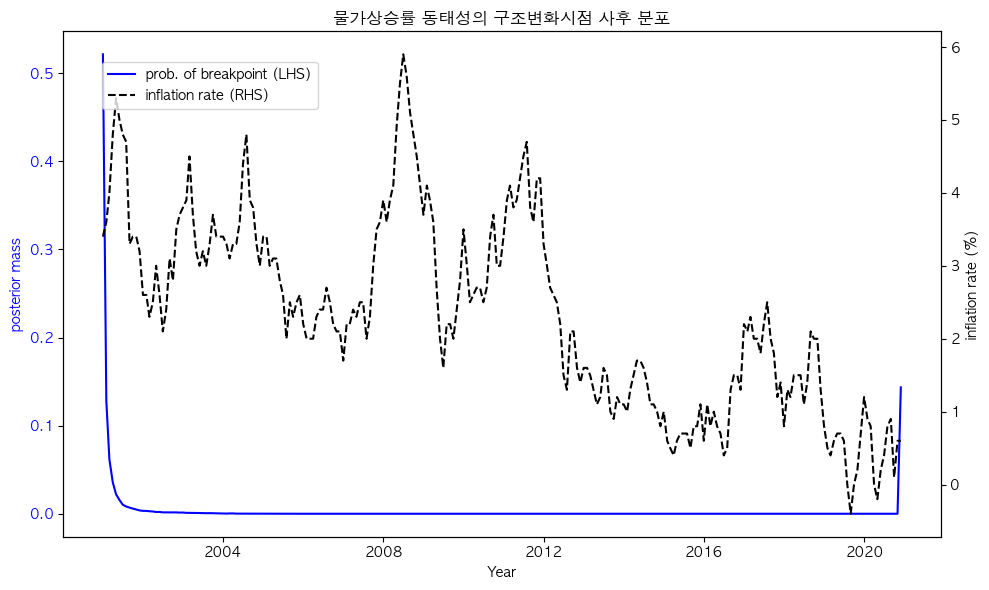

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# 예시 데이터 (실제 데이터로 대체 필요)
tau_posterior = trace.posterior['tau'] # 구조변화 시점의 사후 분포 (예시)
inflation_rate = pce_yoy.values
dates =pce_yoy.index  # 시간 축

# 구조변화 시점의 사후 분포를 계산
# posterior_mass는 각 시점에서 구조변화 시점이 일어날 확률 (예시)
posterior_mass = np.histogram(tau_posterior, bins=len(dates), density=True)[0]

fig, ax1 = plt.subplots(figsize=(10, 6))

# 1. 구조변화 시점의 사후 분포 (좌측 y축)
ax1.plot(dates, posterior_mass, color='blue', label='prob. of breakpoint (LHS)')
ax1.set_ylabel('posterior mass', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 2. 물가 상승률 데이터 (우측 y축)
ax2 = ax1.twinx()
ax2.plot(dates, inflation_rate, 'k--', label='inflation rate (RHS)')
ax2.set_ylabel('inflation rate (%)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# 제목과 레이블 설정
ax1.set_xlabel('Year')
plt.title("물가상승률 동태성의 구조변화시점 사후 분포")

# 범례 설정
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()